In [16]:
import os
import random

# import torch
# from torch import nn
# from torch.utils.data import DataLoader
# from torchvision.transforms import ToTensor

## Dataset Split
Split dataset into train (70%), test (20%) and val (10%)

In [14]:
def create_dataset_splits(root_folder, train_ratio=0.7, val_ratio=0.1, test_ratio=0.2, files_per_class=100):
    """
    Create train, validation, and test splits for audio files while maintaining class balance
    and keeping files ordered by class.
    
    Args:
        root_folder (str): Path to the root folder containing class subfolders
        train_ratio (float): Ratio of files to use for training (default: 0.7)
        val_ratio (float): Ratio of files to use for validation (default: 0.1)
        test_ratio (float): Ratio of files to use for testing (default: 0.2)
        files_per_class (int): Number of files in each class (default: 100)
    """
    # Verify ratios sum to 1
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-5, "Ratios must sum to 1"
    
    # Calculate number of files for each split
    n_train = int(files_per_class * train_ratio)  # 70 files
    n_val = int(files_per_class * val_ratio)      # 10 files
    n_test = files_per_class - n_train - n_val    # 20 files
    
    # Get sorted list of subfolders (classes)
    class_folders = sorted([d for d in os.listdir(root_folder) 
                          if os.path.isdir(os.path.join(root_folder, d))])
    
    # Initialize lists for each split
    train_files = []
    val_files = []
    test_files = []
    
    # Process each class in order
    for class_name in class_folders:
        class_path = os.path.join(root_folder, class_name)
        
        # Get sorted list of audio files
        audio_files = sorted([f for f in os.listdir(class_path)
                            if f.lower().endswith(('.wav', '.mp3', '.flac', '.m4a', '.ogg'))])
        
        assert len(audio_files) == files_per_class, f"Expected {files_per_class} files in {class_name}, found {len(audio_files)}"
        
        # Create relative paths
        class_files = [os.path.join(class_name, f) for f in audio_files]
        
        # Shuffle files while maintaining reproducibility
        random.seed(hash(class_name))  # Use class name as seed for consistent shuffling
        random.shuffle(class_files)
        
        # Split files
        train_files.extend(class_files[:n_train])
        val_files.extend(class_files[n_train:n_train + n_val])
        test_files.extend(class_files[n_train + n_val:])
    
    # Write splits to files, maintaining class order
    def write_split(file_name, files):
        with open(file_name, 'w', encoding='utf-8') as f:
            for file_path in files:
                f.write(f"{file_path}\n")
    
    write_split('../../datasets/train.txt', train_files)
    write_split('../../datasets/val.txt', val_files)
    write_split('../../datasets/test.txt', test_files)
    
    # Print statistics
    print(f"Dataset split complete:")
    print(f"Train set: {len(train_files)} files ({n_train} per class)")
    print(f"Validation set: {len(val_files)} files ({n_val} per class)")
    print(f"Test set: {len(test_files)} files ({n_test} per class)")
    
    # Print class distribution in order
    print("\nClass distribution (in order):")
    for class_name in class_folders:
        train_count = sum(1 for f in train_files if class_name in f)
        val_count = sum(1 for f in val_files if class_name in f)
        test_count = sum(1 for f in test_files if class_name in f)
        print(f"{class_name}:")
        print(f"  Train: {train_count}")
        print(f"  Val: {val_count}")
        print(f"  Test: {test_count}")

if __name__ == "__main__":
    # Set random seed for reproducibility
    random.seed(42)
    
    # Replace with your root folder path
    dataset_path = "../../datasets/genres_original"
    
    create_dataset_splits(dataset_path)

Dataset split complete:
Train set: 700 files (70 per class)
Validation set: 100 files (10 per class)
Test set: 200 files (20 per class)

Class distribution (in order):
blues:
  Train: 70
  Val: 10
  Test: 20
classical:
  Train: 70
  Val: 10
  Test: 20
country:
  Train: 70
  Val: 10
  Test: 20
disco:
  Train: 70
  Val: 10
  Test: 20
hiphop:
  Train: 70
  Val: 10
  Test: 20
jazz:
  Train: 70
  Val: 10
  Test: 20
metal:
  Train: 70
  Val: 10
  Test: 20
pop:
  Train: 70
  Val: 10
  Test: 20
reggae:
  Train: 70
  Val: 10
  Test: 20
rock:
  Train: 70
  Val: 10
  Test: 20


## Data Loader

In [23]:
import os
import random
# import torch
import numpy as np
# import soundfile as sf
import librosa as lb
from torch.utils.data import DataLoader, Dataset
from audiomentations import (
    Compose,
    AddGaussianNoise,
    TimeStretch,
    PitchShift,
    Shift
)
# from torchaudio_augmentations import (
#     RandomResizedCrop,
#     RandomApply,
#     PolarityInversion,
#     Noise,
#     Gain,
#     HighLowPass,
#     Delay,
#     PitchShift,
#     Reverb,
#     Compose,
# )


GTZAN_GENRES = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


class GTZANDataset(Dataset):
    def __init__(self, data_path, split, num_samples, num_chunks):
        self.data_path =  data_path if data_path else ''
        self.split = split
        self.num_samples = num_samples
        self.num_chunks = num_chunks
        # self.is_augmentation = is_augmentation
        self.genres = GTZAN_GENRES
        self._get_song_list()
        # if is_augmentation:
        #     self._get_augmentations()

    def _get_song_list(self):
        list_filename = os.path.join(self.data_path, '%s.txt' % self.split)
        with open(list_filename) as f:
            lines = f.readlines()
        self.song_list = [line.strip() for line in lines]

    def _get_augmentations(self):
        augment = Compose([
            AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
            TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5),
            PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
            Shift(p=0.5)
        ])
        self.augmentation = augment(self.samples, self.sample_rate)

    def _adjust_audio_length(self, wav):
        if self.split == 'train':
            random_index = random.randint(0, len(wav) - self.num_samples - 1)
            wav = wav[random_index : random_index + self.num_samples]
        else:
            hop = (len(wav) - self.num_samples) // self.num_chunks
            wav = np.array([wav[i * hop : i * hop + self.num_samples] for i in range(self.num_chunks)])
        return wav

    def __getitem__(self, index):
        line = self.song_list[index]

        # get genre
        genre_name = line.split('\\')[0]
        genre_index = self.genres.index(genre_name)

        # get audio
        audio_filename = os.path.join(self.data_path, "genres_original", line)
        wav, sample_rate = lb.load(audio_filename)


        # adjust audio length
        wav = self._adjust_audio_length(wav).astype('float32')

        # data augmentation
        # if self.is_augmentation:
        #     samples = self.augmentation(torch.from_numpy(self.samples).unsqueeze(0)).squeeze(0).numpy()

        return wav, genre_index

    def __len__(self):
        return len(self.song_list)

def get_dataloader(data_path=None, 
                   split='train',
                   num_samples=22050 * 29, 
                   num_chunks=1,
                   batch_size=16, 
                   num_workers=0
                   ):
    is_shuffle = True if (split == 'train') else False
    batch_size = batch_size if (split == 'train') else (batch_size // num_chunks)
    data_loader = DataLoader(dataset=GTZANDataset(data_path, 
                                                    split,
                                                    num_samples, 
                                                    num_chunks
                                                ),
                                  batch_size=batch_size,
                                  shuffle=is_shuffle,
                                  drop_last=False,
                                  num_workers=num_workers)
    return data_loader

In [24]:
# Directory
directory="../../datasets/"

# Load train data
train_loader = get_dataloader(data_path=directory, split='train')
iter_train_loader = iter(train_loader)
train_wav, train_genre = next(iter_train_loader)

# Load validation data
valid_loader = get_dataloader(data_path=directory, split='val')

# # Load test data
test_loader = get_dataloader(data_path=directory, split='test')

iter_test_loader = iter(test_loader)
test_wav, test_genre = next(iter_test_loader)
print('training data shape: %s' % str(train_wav.shape))
print('validation/test data shape: %s' % str(test_wav.shape))


training data shape: torch.Size([16, 639450])
validation/test data shape: torch.Size([16, 1, 639450])


## Model

In [25]:
from torch import nn

class Conv_2d(nn.Module):
    def __init__(self, input_channels, output_channels, shape=3, pooling=2, dropout=0.1):
        super(Conv_2d, self).__init__()
        self.conv = nn.Conv2d(input_channels, output_channels, shape, padding=shape//2)
        self.bn = nn.BatchNorm2d(output_channels)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(pooling)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, wav):
        out = self.conv(wav)
        out = self.bn(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.dropout(out)
        return out

In [26]:
import torchaudio
import numpy as np
# import librosa

class CNN(nn.Module):
    def __init__(self, num_channels=16, 
                       sample_rate=22050, 
                       n_fft=1024, 
                       f_min=0.0, 
                       f_max=11025.0, 
                       num_mels=128, 
                       num_classes=10):
        # hop_length=512
        super(CNN, self).__init__()

        # mel spectrogram
        self.melspec = torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate, 
                                                            n_fft=n_fft, 
                                                            f_min=f_min, 
                                                            f_max=f_max, 
                                                            n_mels=num_mels)
        self.amplitude_to_db = torchaudio.transforms.AmplitudeToDB()

        # Librosa alternative: Not feasible due to necessity of audio for function declaration
        # D = np.abs(librosa.stft(y, n_fft = n_fft, hop_length = hop_length))
        # # Convert an amplitude spectrogram to Decibels-scaled spectrogram.
        # DB = librosa.amplitude_to_db(D, ref = np.max)
        self.input_bn = nn.BatchNorm2d(1)

        # convolutional layers
        self.layer1 = Conv_2d(1, num_channels, pooling=(2, 3))
        self.layer2 = Conv_2d(num_channels, num_channels, pooling=(3, 4))
        self.layer3 = Conv_2d(num_channels, num_channels * 2, pooling=(2, 5))
        self.layer4 = Conv_2d(num_channels * 2, num_channels * 2, pooling=(3, 3))
        self.layer5 = Conv_2d(num_channels * 2, num_channels * 4, pooling=(3, 4))

        # dense layers
        self.dense1 = nn.Linear(num_channels * 4, num_channels * 4)
        self.dense_bn = nn.BatchNorm1d(num_channels * 4)
        self.dense2 = nn.Linear(num_channels * 4, num_classes)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()

    def forward(self, wav):
        # input Preprocessing
        out = self.melspec(wav)
        out = self.amplitude_to_db(out)

        # input batch normalization
        out = out.unsqueeze(1)
        out = self.input_bn(out)

        # convolutional layers
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        
        # reshape. (batch_size, num_channels, 1, 1) -> (batch_size, num_channels)
        out = out.reshape(len(out), -1)

        # dense layers
        out = self.dense1(out)
        out = self.dense_bn(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.dense2(out)

        return out

## Training

In [28]:
from sklearn.metrics import accuracy_score, confusion_matrix
import torch


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
cnn = CNN().to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)
valid_losses = []
num_epochs = 1

print('\n' + '='*50)
print('{:^50}'.format('TRAINING CONFIGURATION'))
print('='*50)
print('{:<20} : {}'.format('Device', device))
print('{:<20} : {}'.format('Architecture', 'CNN'))
print('{:<20} : {}'.format('Loss Function', loss_function.__class__.__name__))
print('{:<20} : {}'.format('Optimizer', 'Adam'))
print('{:<20} : {}'.format('Learning Rate', '0.001'))
print('{:<20} : {}'.format('Number of Epochs', num_epochs))
print('='*50 + '\n')

for epoch in range(num_epochs):
    losses = []

    # Train
    cnn.train()
    for (wav, genre_index) in train_loader:
        wav = wav.to(device)
        genre_index = genre_index.to(device)

        # Forward
        out = cnn(wav)
        loss = loss_function(out, genre_index)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    print('Epoch: [%d/%d], Train loss: %.4f' % (epoch+1, num_epochs, np.mean(losses)))

    # Validation
    cnn.eval()
    y_true = []
    y_pred = []
    losses = []
    for wav, genre_index in valid_loader:
        wav = wav.to(device)
        genre_index = genre_index.to(device)

        # reshape and aggregate chunk-level predictions
        b, c, t = wav.size()
        logits = cnn(wav.view(-1, t))
        logits = logits.view(b, c, -1).mean(dim=1)
        loss = loss_function(logits, genre_index)
        losses.append(loss.item())
        _, pred = torch.max(logits.data, 1)

        # append labels and predictions
        y_true.extend(genre_index.tolist())
        y_pred.extend(pred.tolist())
    accuracy = accuracy_score(y_true, y_pred)
    valid_loss = np.mean(losses)
    print('Epoch: [%d/%d], Valid loss: %.4f, Valid accuracy: %.4f' % (epoch+1, num_epochs, valid_loss, accuracy))

    # Save model
    valid_losses.append(valid_loss.item())
    if np.argmin(valid_losses) == epoch:
        print('Saving the best model at %d epochs!' % epoch)
        torch.save(cnn.state_dict(), '../../models/best_model.ckpt')


              TRAINING CONFIGURATION              
Device               : cpu
Architecture         : CNN
Loss Function        : CrossEntropyLoss
Optimizer            : Adam
Learning Rate        : 0.001
Number of Epochs     : 1



KeyboardInterrupt: 

## Evaluation

In [29]:
# Load the best model
S = torch.load('../../models/best_model.ckpt')
cnn.load_state_dict(S)
print('loaded!')

# Run evaluation
cnn.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for wav, genre_index in test_loader:
        wav = wav.to(device)
        genre_index = genre_index.to(device)

        # reshape and aggregate chunk-level predictions
        b, c, t = wav.size()
        logits = cnn(wav.view(-1, t))
        logits = logits.view(b, c, -1).mean(dim=1)
        _, pred = torch.max(logits.data, 1)

        # append labels and predictions
        y_true.extend(genre_index.tolist())
        y_pred.extend(pred.tolist())

C:\Users\Nacho\AppData\Local\Temp\ipykernel_13764\569951515.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  S = torch.load('../../models/best_model.ckpt')


loaded!


### Confusion Matrix

Accuracy: 0.1000


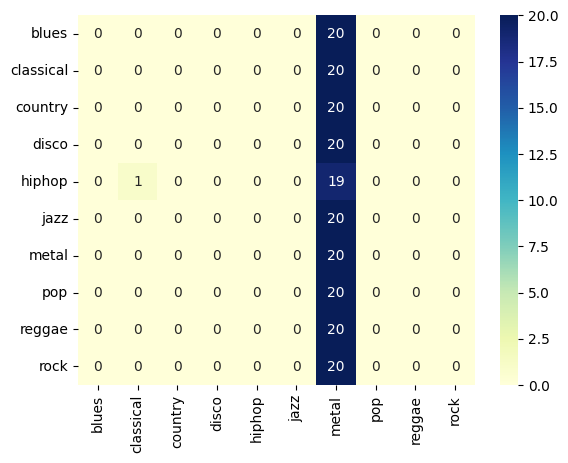

In [30]:
import seaborn as sns
from sklearn.metrics import confusion_matrix


accuracy = accuracy_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, xticklabels=GTZAN_GENRES, yticklabels=GTZAN_GENRES, cmap='YlGnBu')
print('Accuracy: %.4f' % accuracy)